In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

np.set_printoptions(precision=2, suppress=True)

In [24]:
from metric_learn import LMNN
from bottleneck import argpartsort as apts
from tqdm import trange, tqdm
from scipy.stats import mode
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial import cKDTree

class kNearestNeighbors:
    kdtree = None
    k, learn_rate, eps, leafsize = None, None, None, None
    transformer = None
    y = None

    def __init__(self, k=5, learn_rate=1e-7, eps=0, leafsize=100, use_lmnn=True):
        self.k = k
        self.learn_rate = learn_rate
        self.eps = eps
        self.leafsize = leafsize
        self.use_lmnn = use_lmnn
#         print(use_lmnn)

    def fit(self, X, y):
        self.y = y
        try:
            if self.use_lmnn:
                print("Using LMNN...")
                lmnn = LMNN(self.k)
                lmnn.fit(X, y)
                X_lmnn = lmnn.transform(X)
                self.transformer = lmnn.transformer()
                self.kdtree = cKDTree(X_lmnn, leafsize=self.leafsize)
            else:
                self.kdtree = cKDTree(X, leafsize=self.leafsize)
        except AssertionError:
            self.kdtree = cKDTree(X, leafsize=self.leafsize)

    def predict(self, X):
        if self.transformer is not None:
            knn_ind = self.kdtree.query(X @ self.transformer.T, k=self.k, eps=self.eps)[1]
        else:
            knn_ind = self.kdtree.query(X, k=self.k, eps=self.eps)[1]
#         print(y[knn_ind])
        return np.squeeze(mode(self.y[knn_ind], axis=-1)[0])

    def score(self, X, y):
        y_pred = self.predict(X)
#         print(pd.DataFrame({"True": y, "Pred": y_pred}))
        return accuracy_score(y, y_pred)

    def get_params(self, deep=False):
        return {'k': self.k, 'learn_rate': self.learn_rate, 'eps': self.eps, 'leafsize': self.leafsize, 'use_lmnn':self.use_lmnn}
    
    def set_params(self, deep=False):
        params = self.get_params(deep=False)
#         print(params)
        clf = self.__init__(k=params['k'], learn_rate=params['learn_rate'], eps=params['eps'], leafsize=params['leafsize'], use_lmnn=params['use_lmnn'])
        return clf

In [4]:
d = [20, 50, 80, 100]

def generate_subsets(X, y, d, n):
    num_points = d * y.size // 100
    sub_mask = np.zeros(shape=(n, y.size)).astype(bool)
    sub_mask[:, :num_points] = True
    sub_mask = np.apply_along_axis(np.random.permutation, 1, sub_mask)
    X_ret, y_ret = np.tile(X, (n, 1)).reshape(n, *X.shape), np.tile(y, (n, 1)).reshape(n, *y.shape)
    return X_ret[sub_mask].reshape((-1, num_points, X_ret.shape[-1])), y_ret[sub_mask].reshape(-1, num_points)

In [5]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import clone

def my_cross_val_score(clf, X, y, cv):
    skf = StratifiedKFold(y, n_folds=cv)
    accuracies = []
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf_clone = clone(clf)
        clf_clone.fit(X_train, y_train)
        accuracies.append(accuracy_score(y_test, clf_clone.predict(X_test)))
#         print(pd.DataFrame({"True": y_test, "Pred": clf_clone.predict(X_test)}))
    return np.asarray(accuracies)

In [6]:
ds = [20, 50, 80, 100]
ks = [5, 10, 20, 100]
cvs = [2, 5]

def generate_data(X, y, cvs=cvs, ds=ds):
    data_params = []
    ts = (generate_subsets(X, y, d, 5) for d in ds)
    for X_ts, y_ts in ts:
        for X_train, y_train in list(zip(X_ts, y_ts)):
            for cv in cvs:
                data_params.append((X_train, y_train, cv))
    return data_params

In [7]:
from tqdm import tqdm
from joblib import Parallel, delayed

def eval_data(X, y, k, cv, use_lmnn=True):
    data_params = generate_data(X, y, cvs=cv)
    accuracies = np.empty(shape=(len(data_params)), dtype=object)
    pbar = tqdm(total=len(data_params) - 1)
    def calculate(i, X_, y_, cv_, k, pbar):
        knn = kNearestNeighbors(k, use_lmnn=use_lmnn)
        accuracies[i] = my_cross_val_score(knn, X_, y_, cv=cv_)
        pbar.update(1)        
    # Parallel(n_jobs=2)(delayed(calculate)(i, *data_pars, pbar) for i, data_pars in enumerate(data_params))
    for i, data_pars in enumerate(data_params):
        calculate(i, *data_pars, k, pbar)
    return np.hstack(accuracies.flat)

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(results_dict):
    f, ax = plt.subplots(figsize=(9, 9))
    colors = ['blue', 'red', 'green', 'yellow']
    colors = dict(zip(results_dict.keys(), sns.color_palette('hls', len(results_dict))))
#     print(colors)
    for k, scores in results_dict.items():
        sns.distplot(scores, color=colors[k], label=str(k))
        
    Boxes = [item for item in ax.get_children() if isinstance(item, matplotlib.lines.Line2D)][:-1]
#     print(ax.get_children())
    # There is no labels, need to define the labels
    legend_labels  = results_dict.keys()

    # Create the legend patches
    legend_patches = [matplotlib.patches.Patch(linewidth=0.1, color=C, label=L) for
                      C, L in zip([item.get_color() for item in Boxes],
                                  legend_labels)]

    # Plot the legend
    plt.legend(handles=legend_patches)

## Wine Data

In [15]:
path_to_data = '../Data/wine.data'
data = np.genfromtxt(path_to_data, delimiter=',')
X, y = data[:, 1:], data[:, 0].astype(np.int8)

In [16]:
from sklearn.cross_validation import train_test_split
X_td, X_test, y_td, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
from tqdm import tqdm

results = {}
pbar = tqdm([5, 10, 15, 20])
for k in pbar:
    print("Processing k= {}".format(k))
    results[k] = eval_data(X_td, y_td, k, [2, 5])

  0%|          | 0/4 [00:00<?, ?it/s]

Processing k= 5


 25%|██▌       | 1/4 [04:31<13:33, 271.29s/it]

Processing k= 10


  0%|          | 0/39 [00:00<?, ?it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
 50%|█████     | 2/4 [08:57<08:59, 269.92s/it]

Processing k= 15


 75%|███████▌  | 3/4 [14:16<04:44, 284.46s/it]

Processing k= 20


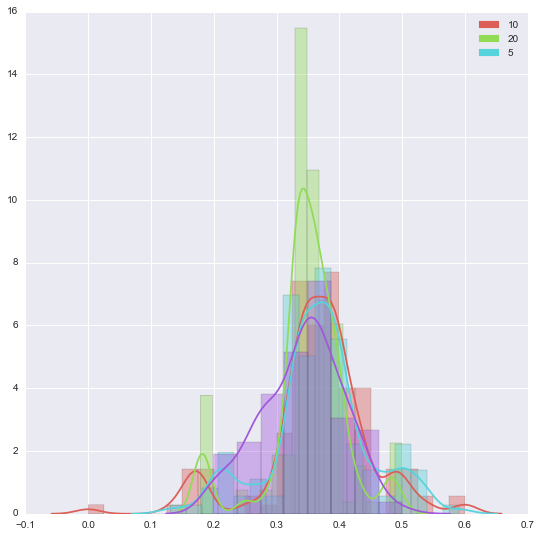

In [22]:
plot_results(results)

In [23]:
from tqdm import tqdm

results = {}
pbar = tqdm([2, 5])
for c in pbar:
    print("Processing c= {}".format(c))
    results[c] = eval_data(X_td, y_td, 10, [c])

  0%|          | 0/2 [00:00<?, ?it/s]

Processing c= 2


 50%|█████     | 1/2 [00:58<00:58, 58.77s/it]

Processing c= 5


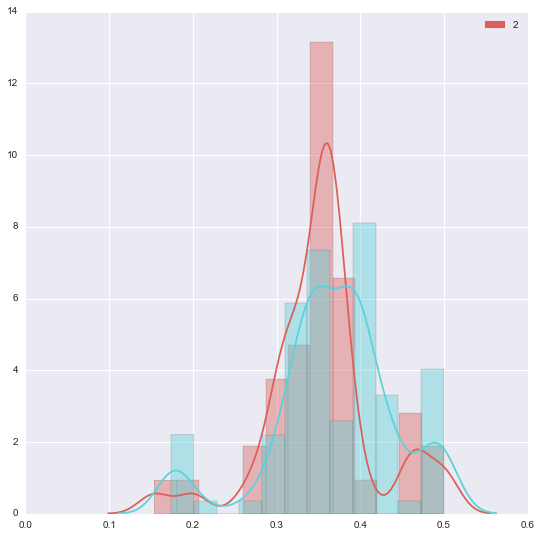

In [24]:
plot_results(results)

# MNIST Data

In [9]:
mnist_data = np.genfromtxt('../Data/MNIST_HW1/train.csv', delimiter=',', dtype=np.float)
mnist_data = mnist_data.T
X_train = mnist_data[:, :-1]
y_train = mnist_data[:, -1].astype(int)

In [10]:
mnist_test_data = np.genfromtxt('../Data/MNIST_HW1/test.csv', delimiter=',', dtype=np.float)
mnist_test_data = mnist_test_data.T
X_test = mnist_test_data[:, :-1]
y_test = mnist_test_data[:, -1].astype(int)

In [27]:
from sklearn.cross_validation import train_test_split

X_td, X_, y_td, y_ = train_test_split(X_train, y_train, train_size=0.1)

In [28]:
from tqdm import tqdm

results = {}
pbar = tqdm([5, 10, 15, 20, 50, 100])
for k in pbar:
    print("Processing k= {}".format(k))
    results[k] = eval_data(X_td, y_td, k, [2, 5, 10], use_lmnn=False)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing k= 5


 17%|█▋        | 1/6 [19:14<1:36:12, 1154.41s/it]

Processing k= 10


 33%|███▎      | 2/6 [38:48<1:17:21, 1160.44s/it]

Processing k= 15


 50%|█████     | 3/6 [58:18<58:09, 1163.33s/it]  

Processing k= 20


 67%|██████▋   | 4/6 [1:17:33<38:41, 1160.57s/it]

Processing k= 50


 83%|████████▎ | 5/6 [1:36:42<19:17, 1157.13s/it]

Processing k= 100


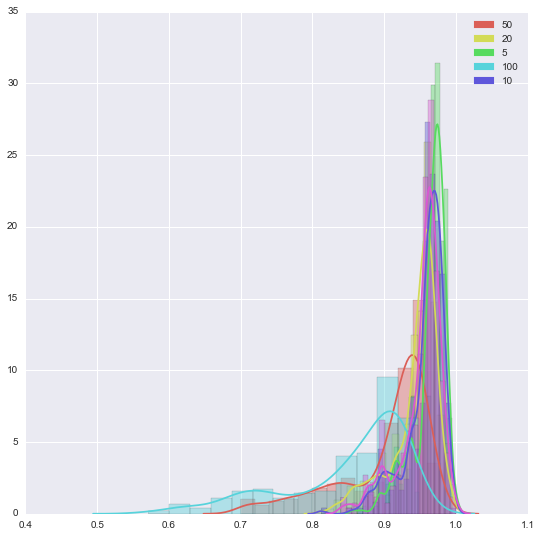

In [29]:
plot_results(results)

From the plot, it's evident that k=5 works really well for MNIST data. We can now try for a better k by visualising the results for k=[3,5,7,9] but the difference won't be much.

In [31]:
from tqdm import tqdm

results = {}
pbar = tqdm([2, 5, 10, 15])
for c in pbar:
    print("Processing c= {}".format(c))
    results[c] = eval_data(X_td, y_td, 5, [c], use_lmnn=False)

  0%|          | 0/4 [00:00<?, ?it/s]

Processing c= 2


 25%|██▌       | 1/4 [01:03<03:10, 63.50s/it]

Processing c= 5


 50%|█████     | 2/4 [06:23<04:40, 140.36s/it]

Processing c= 10


 75%|███████▌  | 3/4 [19:09<05:28, 328.07s/it]

Processing c= 15


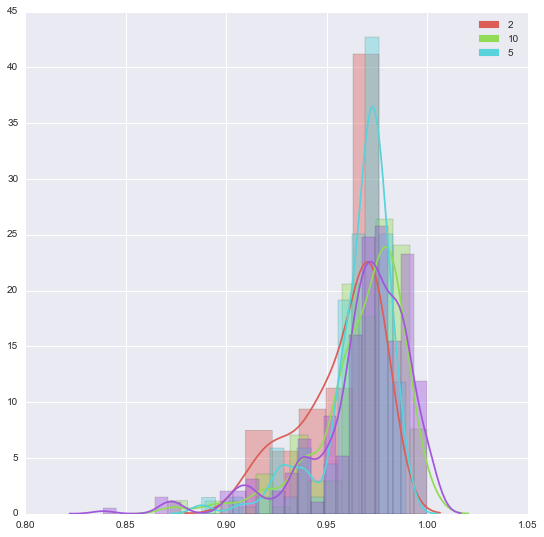

In [32]:
plot_results(results)

Cross validation folds do not seem to have much affect on the data

# Office Data

In [33]:
office_data = np.genfromtxt('../Data/Office/train.csv', delimiter=',', dtype=np.float)
X_train, y_train = office_data[:, :-1], office_data[:, -1].astype(int)

In [34]:
office_test_data = np.genfromtxt('../Data/Office/test.csv', delimiter=',', dtype=np.float)
X_test, y_test = office_test_data[:, :-1], office_test_data[:, -1].astype(int)

In [35]:
from sklearn.cross_validation import train_test_split

X_td, X_, y_td, y_ = train_test_split(X_train, y_train, train_size=0.1)

In [36]:
from tqdm import tqdm

results = {}
pbar = tqdm([5, 10, 15, 20, 50, 100])
for k in pbar:
    print("Processing k= {}".format(k))
    results[k] = eval_data(X_td, y_td, k, [2, 5, 10], use_lmnn=False)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing k= 5


  0%|          | 0/59 [00:00<?, ?it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)
/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
 63%|██████▎   | 37/59 [00:03<00:04,  5.05it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:5

Processing k= 10


  0%|          | 0/59 [00:00<?, ?it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
 33%|███▎      | 2/6 [00:20<00:39,  9.92s/it]

Processing k= 15


 50%|█████     | 3/6 [00:32<00:31, 10.50s/it]

Processing k= 20


 67%|██████▋   | 4/6 [00:45<00:22, 11.38s/it]

Processing k= 50


 83%|████████▎ | 5/6 [01:02<00:13, 13.04s/it]

Processing k= 100


 63%|██████▎   | 37/59 [00:08<00:10,  2.15it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
 64%|██████▍   | 38/59 [00:09<00:09,  2.12it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


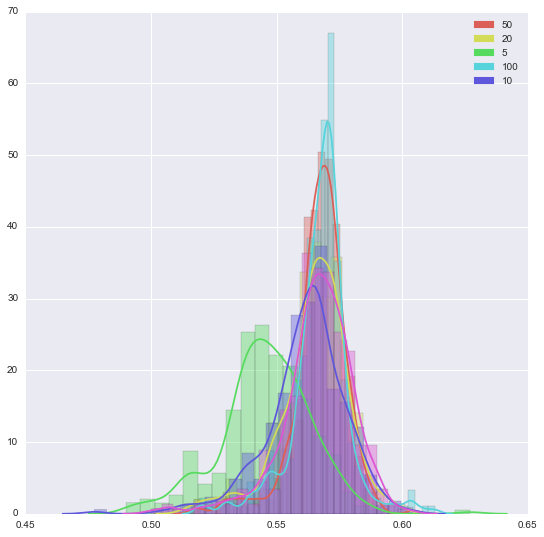

In [37]:
plot_results(results)

From the plot, it's evident that k=5 works badly for Office data. There isn't an appreciable difference in the remaining values.

In [38]:
from tqdm import tqdm

results = {}
pbar = tqdm([2, 5, 10, 15])
for c in pbar:
    print("Processing c= {}".format(c))
    results[c] = eval_data(X_td, y_td, 5, [c], use_lmnn=False)

  0%|          | 0/4 [00:00<?, ?it/s]

Processing c= 2


  0%|          | 0/19 [00:00<?, ?it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)
 25%|██▌       | 1/4 [00:02<00:07,  2.61s/it]

Processing c= 5


  0%|          | 0/19 [00:00<?, ?it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
 37%|███▋      | 7/19 [00:00<00:00, 12.75it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
 68%|██████▊   | 13/19 [00:01<00:01,  5.86it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
 50%|█████     | 2/4 [00:06<00:05, 

Processing c= 10


  0%|          | 0/19 [00:00<?, ?it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
 75%|███████▌  | 3/4 [00:09<00:03,  3.11s/it]

Processing c= 15


  0%|          | 0/19 [00:00<?, ?it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=15.
  % (min_labels, self.n_folds)), Warning)
 21%|██        | 4/19 [00:00<00:00, 16.18it/s]/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=15.
  % (min_labels, self.n_folds)), Warning)
/Users/Aditya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=15.
  % (min_labels, self.n_folds)), Warning)


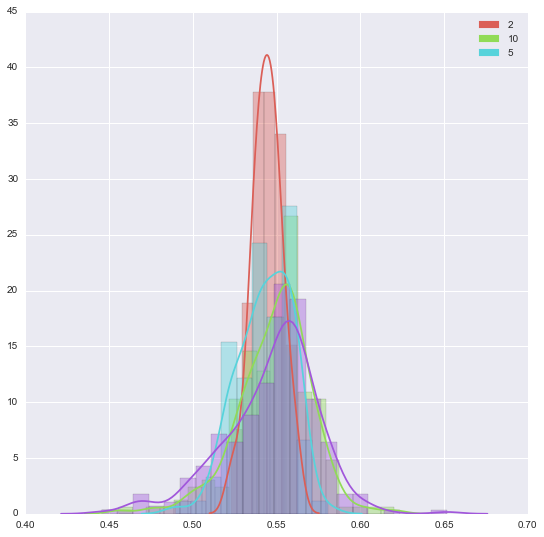

In [39]:
plot_results(results)

Cross validation folds do not seem to have much affect on the data

From all the plots, and the data it seems that as the size of TS increases, the stability of results increases. For very small TS, the results are highly volatile, and contribute to the extreme ends of the plots.